In [3]:
import os
!mkdir content
!gdown 1qaY_h_S3xUezccIDaTSmz2pgJ3KHci2D
!mv data_lab2c.zip content/
!unzip content/data_lab2c.zip

mkdir: content: File exists
/Users/varunchitturi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1qaY_h_S3xUezccIDaTSmz2pgJ3KHci2D
From (redirected): https://drive.google.com/uc?id=1qaY_h_S3xUezccIDaTSmz2pgJ3KHci2D&confirm=t&uuid=698e5667-6a3f-4362-b208-602053147b79
To: /Users/varunchitturi/Desktop/data_lab2c.zip
100%|████████████████████████████████████████| 314M/314M [00:12<00:00, 25.9MB/s]
Archive:  content/data_lab2c.zip
  inflating: test_audios_3.pt        
  inflating: test_labels_3.pt        
  inflating: train_audios_3.pt       
  inflating: train_labels_3.pt       


In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

import os
import numpy as np

device = "mps"

In [2]:
trainAudios = torch.load('train_audios_3.pt')
trainLabels = torch.load('train_labels_3.pt')
testAudios = torch.load('test_audios_3.pt')
testLabels = torch.load('test_labels_3.pt')

Shape of signal: torch.Size([1, 8000])
Sample rate of signal : 8000
1
tensor([ 0.0003, -0.0017, -0.0006,  ..., -0.0006, -0.0005, -0.0007])


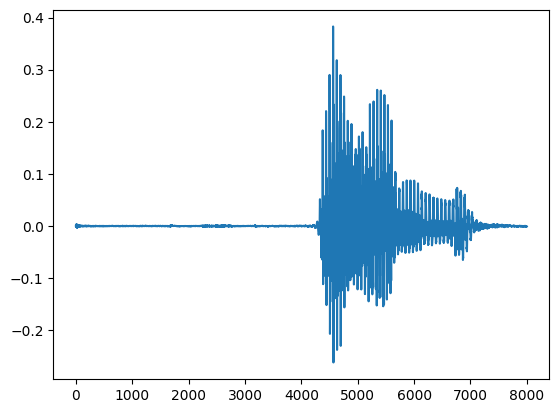

In [3]:
sampleRate = 8000
sample = trainAudios[0]
label = trainLabels[0]
print("Shape of signal: {}".format(sample.size()))
print("Sample rate of signal : {}".format(sampleRate))
print(label.item())
print(sample.squeeze())
plt.plot(sample.squeeze().numpy())
display(ipd.Audio(sample, rate=sampleRate))

In [4]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 64

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(trainAudios, trainLabels), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(testAudios, testLabels), batch_size=batch_size, shuffle=False)

In [5]:
def convolution1(signal, filter):
  taps = conv_filter.shape[0]
  out_features = conv_filter.shape[1]
  N = signal.shape[-1]
  z = torch.zeros((out_features, N))
  for k in range(taps):
    z = z + torch.matmul(conv_filter[k] , signal)
    signal = signal.roll(1,)
    signal[:,0] = 0
  return z

In [6]:
class readoutLayer(nn.Module):
    def __init__(self, input_length, classes):
        super().__init__()
        self.filter = torch.nn.Parameter(torch.empty((classes, input_length)))
        nn.init.xavier_normal_(self.filter)

    def forward(self,x):
        return x @ self.filter.T

class conLayer(nn.Module):
    def __init__(self, in_features, out_features, kernel_size):
        super().__init__()
        self.filter = torch.nn.Parameter(torch.empty(kernel_size, out_features, in_features))
        nn.init.xavier_normal_(self.filter)

    def forward(self,x):
        return convolution1(x, self.filter)

class CNN(nn.Module):
    def __init__(self, n_input, n_output, n_channel, kernel_sizes):
        super().__init__()
        input_length = sampleRate
        dim = n_channel[1] * input_length
        self.conv1 = nn.Conv1d(n_input, n_channel[0], kernel_size = kernel_sizes[0], padding='same')
        self.conv2 = nn.Conv1d(n_channel[0], n_channel[1], kernel_size = kernel_sizes[1], padding='same')
        self.fc1 = readoutLayer(dim, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        return x

In [7]:
def train(model, epoch, log_interval):
    cross_entropy = nn.CrossEntropyLoss()
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        losses = []
        data = data.to(device)
        target = target.to(device)

        output = model(data).squeeze()

        loss = cross_entropy(output, target.type(torch.LongTensor).to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx:
          print(f"Train Epoch: {epoch} \tLoss: {loss.item():.3f}")

        losses.append(loss.item())

In [8]:
def isCorrect(pred, target):
    num_correct = torch.sum(pred == target)
    return num_correct

def getIndex(tensor):
    return tensor.argmax(dim = -1)

def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)
        output = model(data)

        pred = getIndex(output)
        correct += isCorrect(pred, target)

    print("Test Epoch: " + str(epoch))
    print("Accuracy: " + str(correct/len(test_loader.dataset)) + str( 100 * correct/len(test_loader.dataset)))

    return correct/len(test_loader.dataset)

CNN(
  (conv1): Conv1d(1, 8, kernel_size=(80,), stride=(1,), padding=same)
  (pool1): max_pool_1d()
  (conv2): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=same)
  (pool2): max_pool_1d()
  (fc1): readoutLayer()
)
Number of parameters:SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Train Epoch: 1 	Loss: 1.105
Train Epoch: 1 	Loss: 1.111
Train Epoch: 1 	Loss: 1.098
Train Epoch: 1 	Loss: 1.100
Train Epoch: 1 	Loss: 1.107
Train Epoch: 1 	Loss: 1.109
Train Epoch: 1 	Loss: 1.098
Train Epoch: 1 	Loss: 1.112
Train Epoch: 1 	Loss: 1.106
Train Epoch: 1 	Loss: 1.089
Train Epoch: 1 	Loss: 1.098
Train Epoch: 1 	Loss: 1.111
Train Epoch: 1 	Loss: 1.101
Train Epoch: 1 	Loss: 1.107
Train Epoch: 1 	Loss: 1.103
Train Epoch: 1 	Loss: 1.102
Train Epoch: 1 	Loss: 1.117
Train Epoch: 1 	Loss: 1.098
Train Epoch: 1 	Loss: 1.111
Train Epoch: 1 	Loss: 1.112
Train Epoch: 1 	Loss: 1

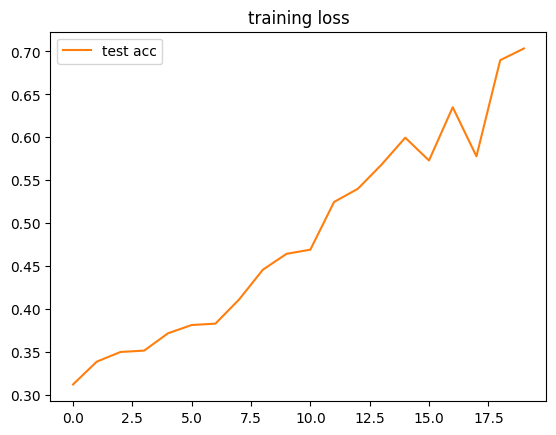

In [32]:
logInterval = 50
nEpoch = 20

model = CNN(n_input=1, n_output=3, n_channel=[8, 8], kernel_sizes = [80, 3])
model.to("mps")
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n = count_parameters(model)
optimizer = optim.SGD(model.parameters(), lr=0.01)
print("Number of parameters:" + str(optimizer))

losses = []
test_acc = []

for epoch in range(1, (nEpoch + 1)):
    train(model, epoch, logInterval)
    test_acc.append(test(model, epoch).cpu())

plt.plot(losses)
plt.title("training loss")
plt.plot(test_acc, label = 'test acc')
plt.legend()

In [68]:
class max_pool_1d(nn.Module):
    # Implements max pooling in a vectorized, faster fashion.
    def __init__(self, pool_size, device='cpu'):
        super().__init__()
        self.poolsize = pool_size
        self.device = device

    def forward(self, signal):
        output_length = int(signal.shape[-1]/self.poolsize)
        signal = signal.reshape((signal.shape[0], signal.shape[1], output_length, -1)).to(self.device)
        pooled_signal = torch.max(signal,dim=-1).values
        return pooled_signal

class average_pool_1d(nn.Module):
    # Implements the average pooling in a vectorized, faster fashion.
    def __init__(self, pool_size, device='cpu'):
        super().__init__()
        self.poolsize = pool_size
        self.device = device

    def forward(self, signal):
        output_length = int(signal.shape[-1]/self.poolsize)
        signal = signal.reshape((signal.shape[0],signal.shape[1],output_length,-1)).to(self.device)
        pooled_signal = torch.mean(signal,dim=-1)

        return pooled_signal

class CNN(nn.Module):
    def __init__(self, n_input=1, n_output=3, n_channel=[8, 8, 8, 8], kernel_sizes = [80, 80, 80, 3], pooling_windows = [8, 8, 5, 5]):
        super().__init__()
        input_length = 8000
        emb_dim = int(n_channel[3]*input_length/(8*8*5*5))
        self.conv1 = nn.Conv1d(n_input, n_channel[0], kernel_size=kernel_sizes[0], padding='same')
        self.pool1 = max_pool_1d(pooling_windows[0])
        self.conv2 = nn.Conv1d(n_channel[0], n_channel[1], kernel_size=kernel_sizes[1], padding='same')
        self.pool2 = max_pool_1d(pooling_windows[1])
        self.conv3 = nn.Conv1d(n_channel[1], n_channel[2], kernel_size=kernel_sizes[2], padding='same')
        self.pool3 = max_pool_1d(pooling_windows[2])
        self.conv4 = nn.Conv1d(n_channel[2], n_channel[3], kernel_size=kernel_sizes[3], padding='same')
        self.pool4 = max_pool_1d(pooling_windows[3])
        self.fc1 = readoutLayer(emb_dim, n_output)

    def forward(self, x):
      x = self.conv1(x)
      x = F.relu(x)
      x = self.pool1(x).to(device)
      x = self.conv2(x)
      x = F.relu(x)
      x = self.pool2(x).to(device)
      x = self.conv3(x)
      x = F.relu(x)
      x = self.pool3(x).to(device)
      x = self.conv4(x)
      x = F.relu(x)
      x = self.pool4(x).to(device)
      x = torch.flatten(x, start_dim=1) # Vectorization operation
      x = self.fc1(x)
      return x

CNN(
  (conv1): Conv1d(1, 8, kernel_size=(80,), stride=(1,), padding=same)
  (pool1): max_pool_1d()
  (conv2): Conv1d(8, 8, kernel_size=(80,), stride=(1,), padding=same)
  (pool2): max_pool_1d()
  (conv3): Conv1d(8, 8, kernel_size=(80,), stride=(1,), padding=same)
  (pool3): max_pool_1d()
  (conv4): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=same)
  (pool4): max_pool_1d()
  (fc1): readoutLayer()
)
Train Epoch: 1 	Loss: 1.116
Train Epoch: 1 	Loss: 1.128
Train Epoch: 1 	Loss: 1.095
Train Epoch: 1 	Loss: 1.095
Train Epoch: 1 	Loss: 1.118
Train Epoch: 1 	Loss: 1.103
Train Epoch: 1 	Loss: 1.095
Train Epoch: 1 	Loss: 1.097
Train Epoch: 1 	Loss: 1.095
Train Epoch: 1 	Loss: 1.099
Train Epoch: 1 	Loss: 1.097
Train Epoch: 1 	Loss: 1.093
Train Epoch: 1 	Loss: 1.114
Train Epoch: 1 	Loss: 1.094
Train Epoch: 1 	Loss: 1.097
Train Epoch: 1 	Loss: 1.084
Train Epoch: 1 	Loss: 1.092
Train Epoch: 1 	Loss: 1.116
Train Epoch: 1 	Loss: 1.102
Train Epoch: 1 	Loss: 1.099
Train Epoch: 1 	Loss: 1.100
Tr

Text(0.5, 1.0, 'training loss')

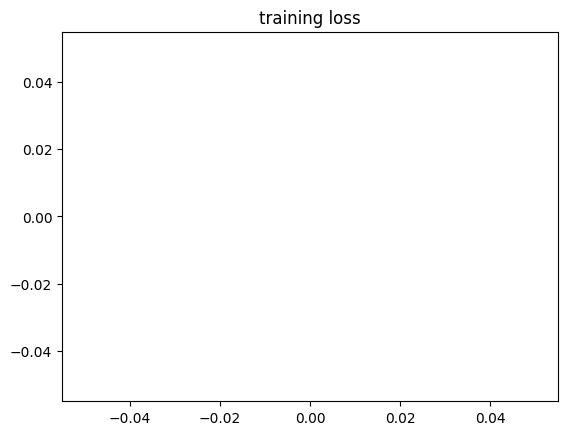

In [69]:
log_interval = 50
n_epoch = 20

model = CNN(n_input=1, n_output=3, n_channel=[8, 8, 8, 8], kernel_sizes = [80, 80, 80, 3])
model.to(device)
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

optimizer = optim.SGD(model.parameters(), lr=0.03)

losses = []
test_acc = []

for epoch in range(1, n_epoch + 1):
    train(model, epoch, log_interval)
    test_acc.append(test(model, epoch).cpu())

# Let's plot the training loss versus the number of iteration.
plt.plot(losses)
plt.title("training loss")


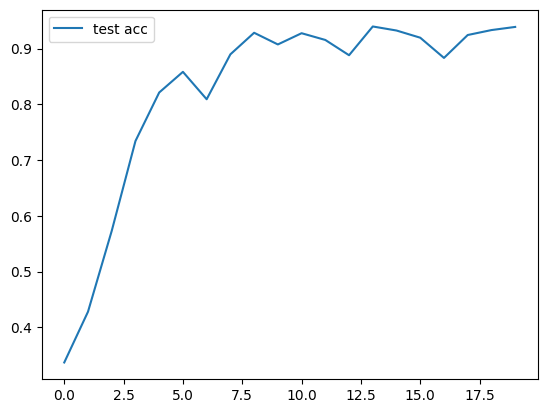

In [70]:
 plt.plot(test_acc, label = 'test acc')
plt.legend()

In [71]:
print(test_acc[-1])

tensor(0.9388)
